In [36]:
%store -r train
%store -r test
%store -r dt_train
%store -r dt_test
%store -r preds
%run ../src/utils.py

# Residual Learning

A pattern analysis on the data predicted wrongly by our model may give insights on blindspot data complexity.

For convenience and clarity, some variables coming from the wrong predictions will be prefixed with `w_`, and some among the right ones will have the `r_` prefix.

In [2]:
target = ['is_inside_city_exit']

preds_column = np.array([preds]).T
dt_test['correct_prediction'] = dt_test[target].values == preds_column

wrong_preds = dt_test[dt_test.correct_prediction == False]
right_preds = dt_test[dt_test.correct_prediction == True]
wrong_preds.shape[0], right_preds.shape[0]

(1728, 25085)

In [3]:
wrong_preds['is_inside_city_exit'].value_counts()

1    1184
0     544
Name: is_inside_city_exit, dtype: int64

In [5]:
right_preds['is_inside_city_exit'].value_counts()

0    18907
1     6178
Name: is_inside_city_exit, dtype: int64

# Distance Analysis

## Shortest Trajectories
First parameter to be observed is distance. We'll start by sorting by the shortest of distances among travels.

Text(0.5, 1.0, 'right_preds\nShortest travels')

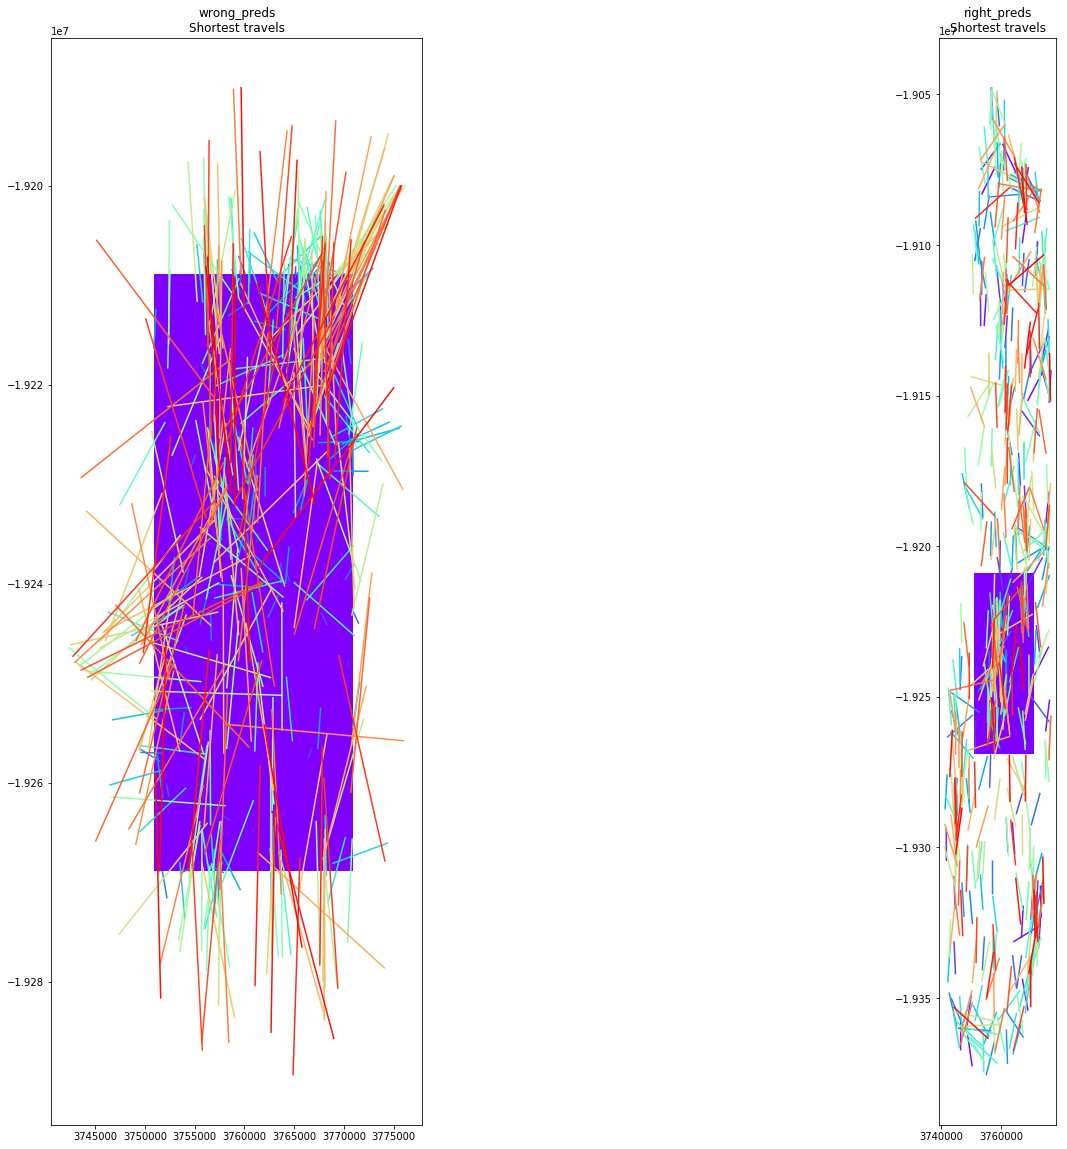

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25, 20))
w_short_travels = wrong_preds.sort_values('distance', ascending=True)
r_short_travels = right_preds.sort_values('distance', ascending=True)

geoplot(w_short_travels.head(700), ax=ax1)
ax1.set_title('wrong_preds\nShortest travels')

geoplot(r_short_travels[
    r_short_travels.distance > w_short_travels.head(700).distance.mean()
].head(800), ax=ax2)
ax2.set_title('right_preds\nShortest travels')

From the above plot, we can quickly conclude the correctly predicted shortest travels are much more sparsely distributed in space than the ones predicted wrong.

More than 66% of the wrong predictions were on routes ending inside the city center, while the scenario is the inverse for correct predictions. 

In [7]:
# Shortest 50% out of all travels
w_samples = w_short_travels.head(len(wrong_preds)//2).copy()

w_short_staying_in = w_samples[(w_samples.is_inside_city_entry == 1) & (w_samples.is_inside_city_exit == 1)]
w_short_staying_out = w_samples[(w_samples.is_inside_city_entry == 0) & (w_samples.is_inside_city_exit == 0)]
w_short_leaving_center = w_samples[(w_samples.is_inside_city_entry == 1) & (w_samples.is_inside_city_exit == 0)]
w_short_entering_center = w_samples[(w_samples.is_inside_city_entry == 0) & (w_samples.is_inside_city_exit == 1)]

print('Staying inside center\t{}'.format(len(w_short_staying_in) / len(w_samples)))
print('Staying outside center\t{}'.format(len(w_short_staying_out) / len(w_samples)))
print('Leaving center\t\t{}'.format(len(w_short_leaving_center) / len(w_samples)))
print('Entering center\t\t{}'.format(len(w_short_entering_center) / len(w_samples)))

Staying inside center	0.41782407407407407
Staying outside center	0.004629629629629629
Leaving center		0.2650462962962963
Entering center		0.3125


In [8]:
# Shortest 50% out of all travels
r_samples = r_short_travels.head(len(right_preds)//2).copy()

r_short_staying_in = r_samples[(r_samples.is_inside_city_entry == 1) & (r_samples.is_inside_city_exit == 1)]
r_short_staying_out = r_samples[(r_samples.is_inside_city_entry == 0) & (r_samples.is_inside_city_exit == 0)]
r_short_leaving_center = r_samples[(r_samples.is_inside_city_entry == 1) & (r_samples.is_inside_city_exit == 0)]
r_short_entering_center = r_samples[(r_samples.is_inside_city_entry == 0) & (r_samples.is_inside_city_exit == 1)]

print('Staying inside center\t{}'.format(len(r_short_staying_in) / len(r_samples)))
print('Staying outside center\t{}'.format(len(r_short_staying_out) / len(r_samples)))
print('Leaving center\t\t{}'.format(len(r_short_leaving_center) / len(r_samples)))
print('Entering center\t\t{}'.format(len(r_short_entering_center) / len(r_samples)))

Staying inside center	0.29086270132355285
Staying outside center	0.7091372986764471
Leaving center		0.0
Entering center		0.0


The percentual distributions are blaringly antagonic.

While 70% of `r_` shortest travels stay outside the city center (which can be seen in the previopus plot), practically 0% of `w_` shortest travels fall in that scenario.

Meanwhile, two scenarios that represent 0% of `r_` shortest travels, represent more than 50% of `w_`: 31% travels entering the city center, 26% exiting.

Let's isolate those groups to close into their patterns.

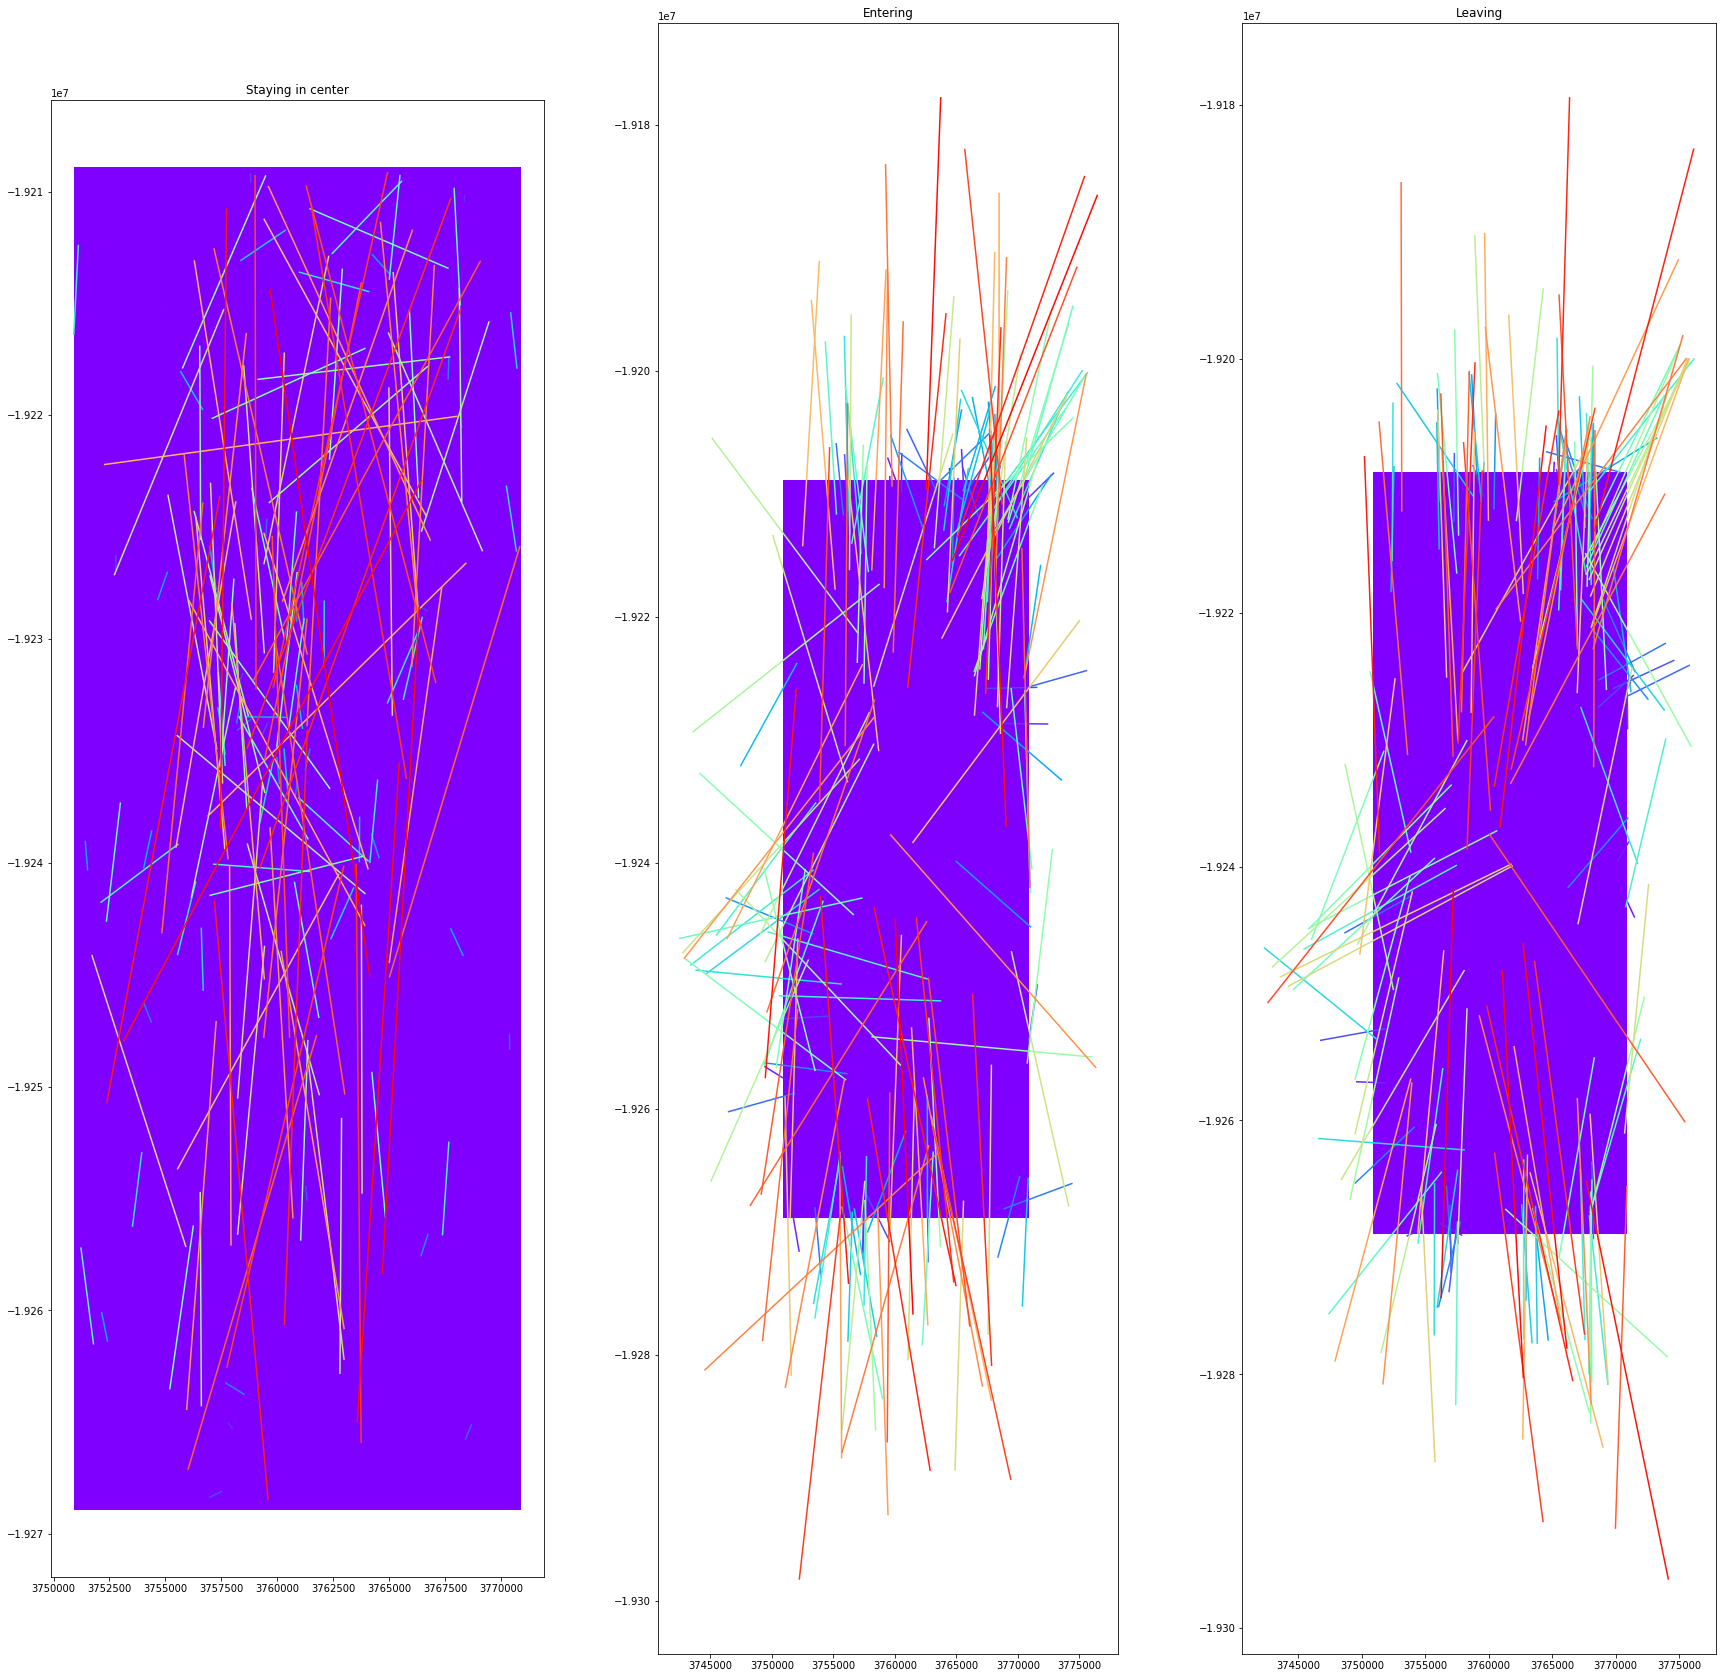

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(30, 30))

ax1.set_title('Staying in center')
geoplot(w_short_staying_in.head(500), ax=ax1)
ax2.set_title('Entering')
geoplot(w_short_entering_center.head(500), ax=ax2)
ax3.set_title('Leaving')
geoplot(w_short_leaving_center.head(500), ax=ax3)


Entry and exit travels follow seemingly the same angulation and spatial distribution patterns, which likely points to transportation disposition along city center borders.

Now, for the `w_` travels that stay in the city center, there's a notable distance from the vertexes, probably a result of centralized urbanization, or merely a global lack of points of interest for everyone in `w_` at that time of day.

C:\Users\julio\Anaconda3\envs\eygeo\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\julio\Anaconda3\envs\eygeo\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\julio\Anaconda3\envs\eygeo\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\julio\Anaconda3\envs\eygeo\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, *

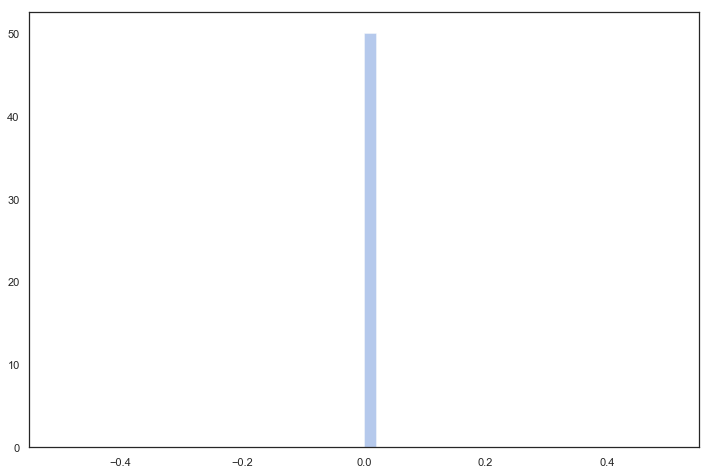

In [10]:
distplot(r_samples, 'distance')

In [11]:
len(right_preds[right_preds.distance == 0]) / len(right_preds)

0.5347418776161053

Curiously, more than half of all correctly predicted trajectories have 0-valued distances. The `r_` values we plotted are the first few non-0 trajectories in `right_preds`.

## Longest Trajectories
Let's now take a look at the logest travels in both sets.

Text(0.5, 1.0, 'right_preds\nLongest travels')

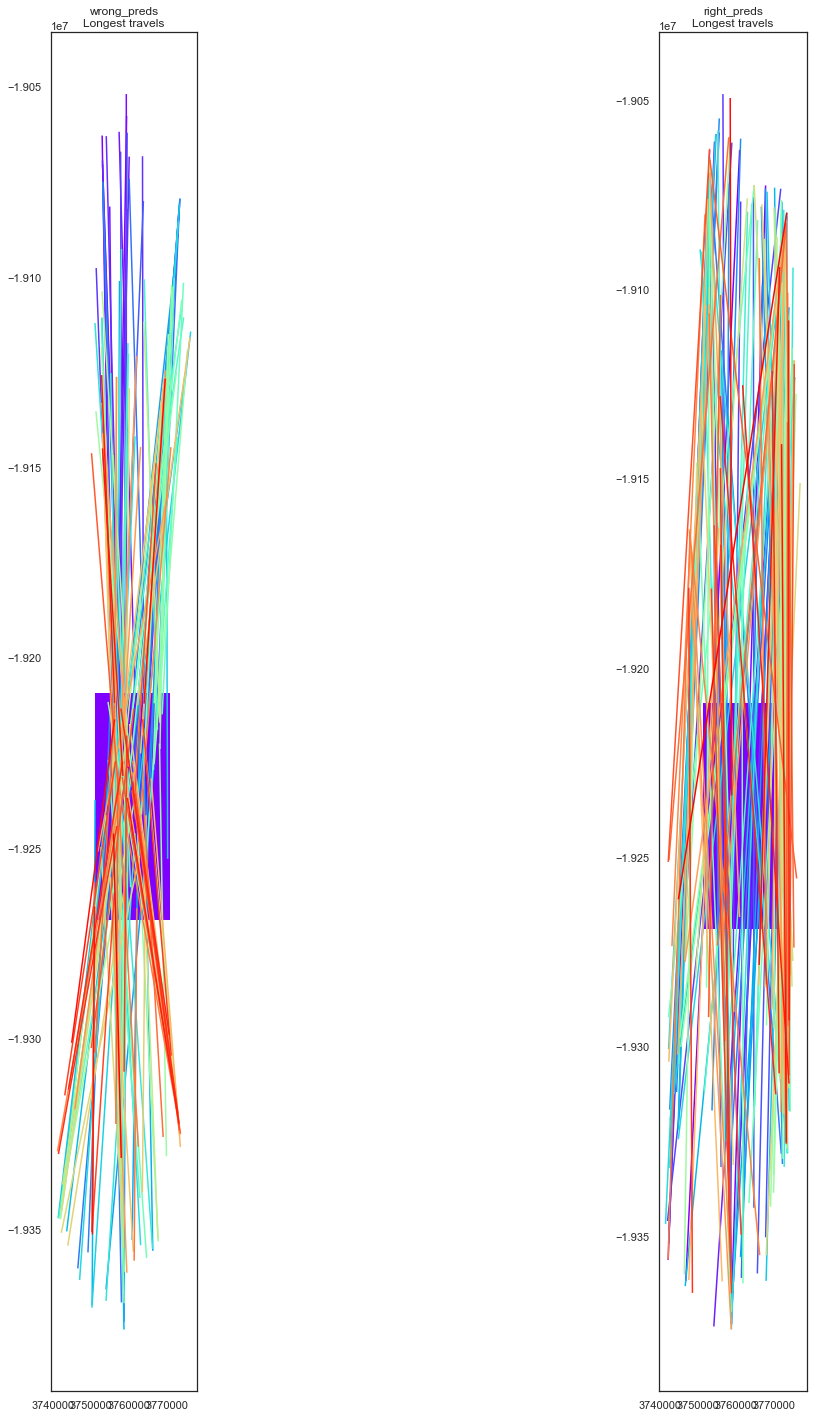

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 25))

w_long_travels = wrong_preds.sort_values('distance', ascending=False)
r_long_travels = right_preds.sort_values('distance', ascending=False)

geoplot(w_long_travels.head(300), ax=ax1)
ax1.set_title('wrong_preds\nLongest travels')
geoplot(r_long_travels.head(300), ax=ax2)
ax2.set_title('right_preds\nLongest travels')

In [13]:
# Shortest 50% out of all travels
r_samples = r_long_travels.head(len(right_preds)//2).copy()
w_samples = w_long_travels.head(len(wrong_preds)//2).copy()

w_samples['center_permanency'].mean(), r_samples['center_permanency'].mean()

(0.4315189654990974, 0.23693945219535859)

Another clear difference in spatial dispositions - long distance travels in `r_` have a much more vertical alignment when compared to those in `w_`, which have coniderably higher x-deltas, so that they diagonally draw an `X` across the city center.

Moreover, only 23% of distances from `r_` are taken trespassing the center, versus 43% in those we couldn't predict. Dense clusters of trajectories in `r_` can be seen passing to the left and right of the center polygon, unlike the centralized convergence pattern seen from `w_`.

That could indicate that the portion of long distance travelers who fell in `w_` may be taking different means of transport - a railway line, avenue etc - uncommon to the larger distribution of long travels in `r_`.

In [14]:
w_long_staying_in = w_samples[(w_samples.is_inside_city_entry == 1) & (w_samples.is_inside_city_exit == 1)]
w_long_staying_out = w_samples[(w_samples.is_inside_city_entry == 0) & (w_samples.is_inside_city_exit == 0)]
w_long_leaving_center = w_samples[(w_samples.is_inside_city_entry == 1) & (w_samples.is_inside_city_exit == 0)]
w_long_entering_center = w_samples[(w_samples.is_inside_city_entry == 0) & (w_samples.is_inside_city_exit == 1)]

print('Staying inside center\t{}'.format(len(w_long_staying_in) / len(w_samples)))
print('Staying outside center\t{}'.format(len(w_long_staying_out) / len(w_samples)))
print('Leaving center\t\t{}'.format(len(w_long_leaving_center) / len(w_samples)))
print('Entering center\t\t{}'.format(len(w_long_entering_center) / len(w_samples)))

Staying inside center	0.04050925925925926
Staying outside center	0.004629629629629629
Leaving center		0.35532407407407407
Entering center		0.5995370370370371


In [15]:
r_long_staying_in = r_samples[(r_samples.is_inside_city_entry == 1) & (r_samples.is_inside_city_exit == 1)]
r_long_staying_out = r_samples[(r_samples.is_inside_city_entry == 0) & (r_samples.is_inside_city_exit == 0)]
r_long_leaving_center = r_samples[(r_samples.is_inside_city_entry == 1) & (r_samples.is_inside_city_exit == 0)]
r_long_entering_center = r_samples[(r_samples.is_inside_city_entry == 0) & (r_samples.is_inside_city_exit == 1)]

print('Staying inside center\t{}'.format(len(r_long_staying_in) / len(r_samples)))
print('Staying outside center\t{}'.format(len(r_long_staying_out) / len(r_samples)))
print('Leaving center\t\t{}'.format(len(r_long_leaving_center) / len(r_samples)))
print('Entering center\t\t{}'.format(len(r_long_entering_center) / len(r_samples)))

Staying inside center	0.19980864295965556
Staying outside center	0.7461329931430394
Leaving center		0.053420507096156915
Entering center		0.0006378568011481422


The flow discrepancies hold up for the longest-route half of our `w_` / `r_` data.

While all of `w_` are either entering (59%) or leaving (35%) the center, the ones in `r_` are staying - either outside (74%) or inside it (20%). Let's look closer to those 4 groups in isolation.

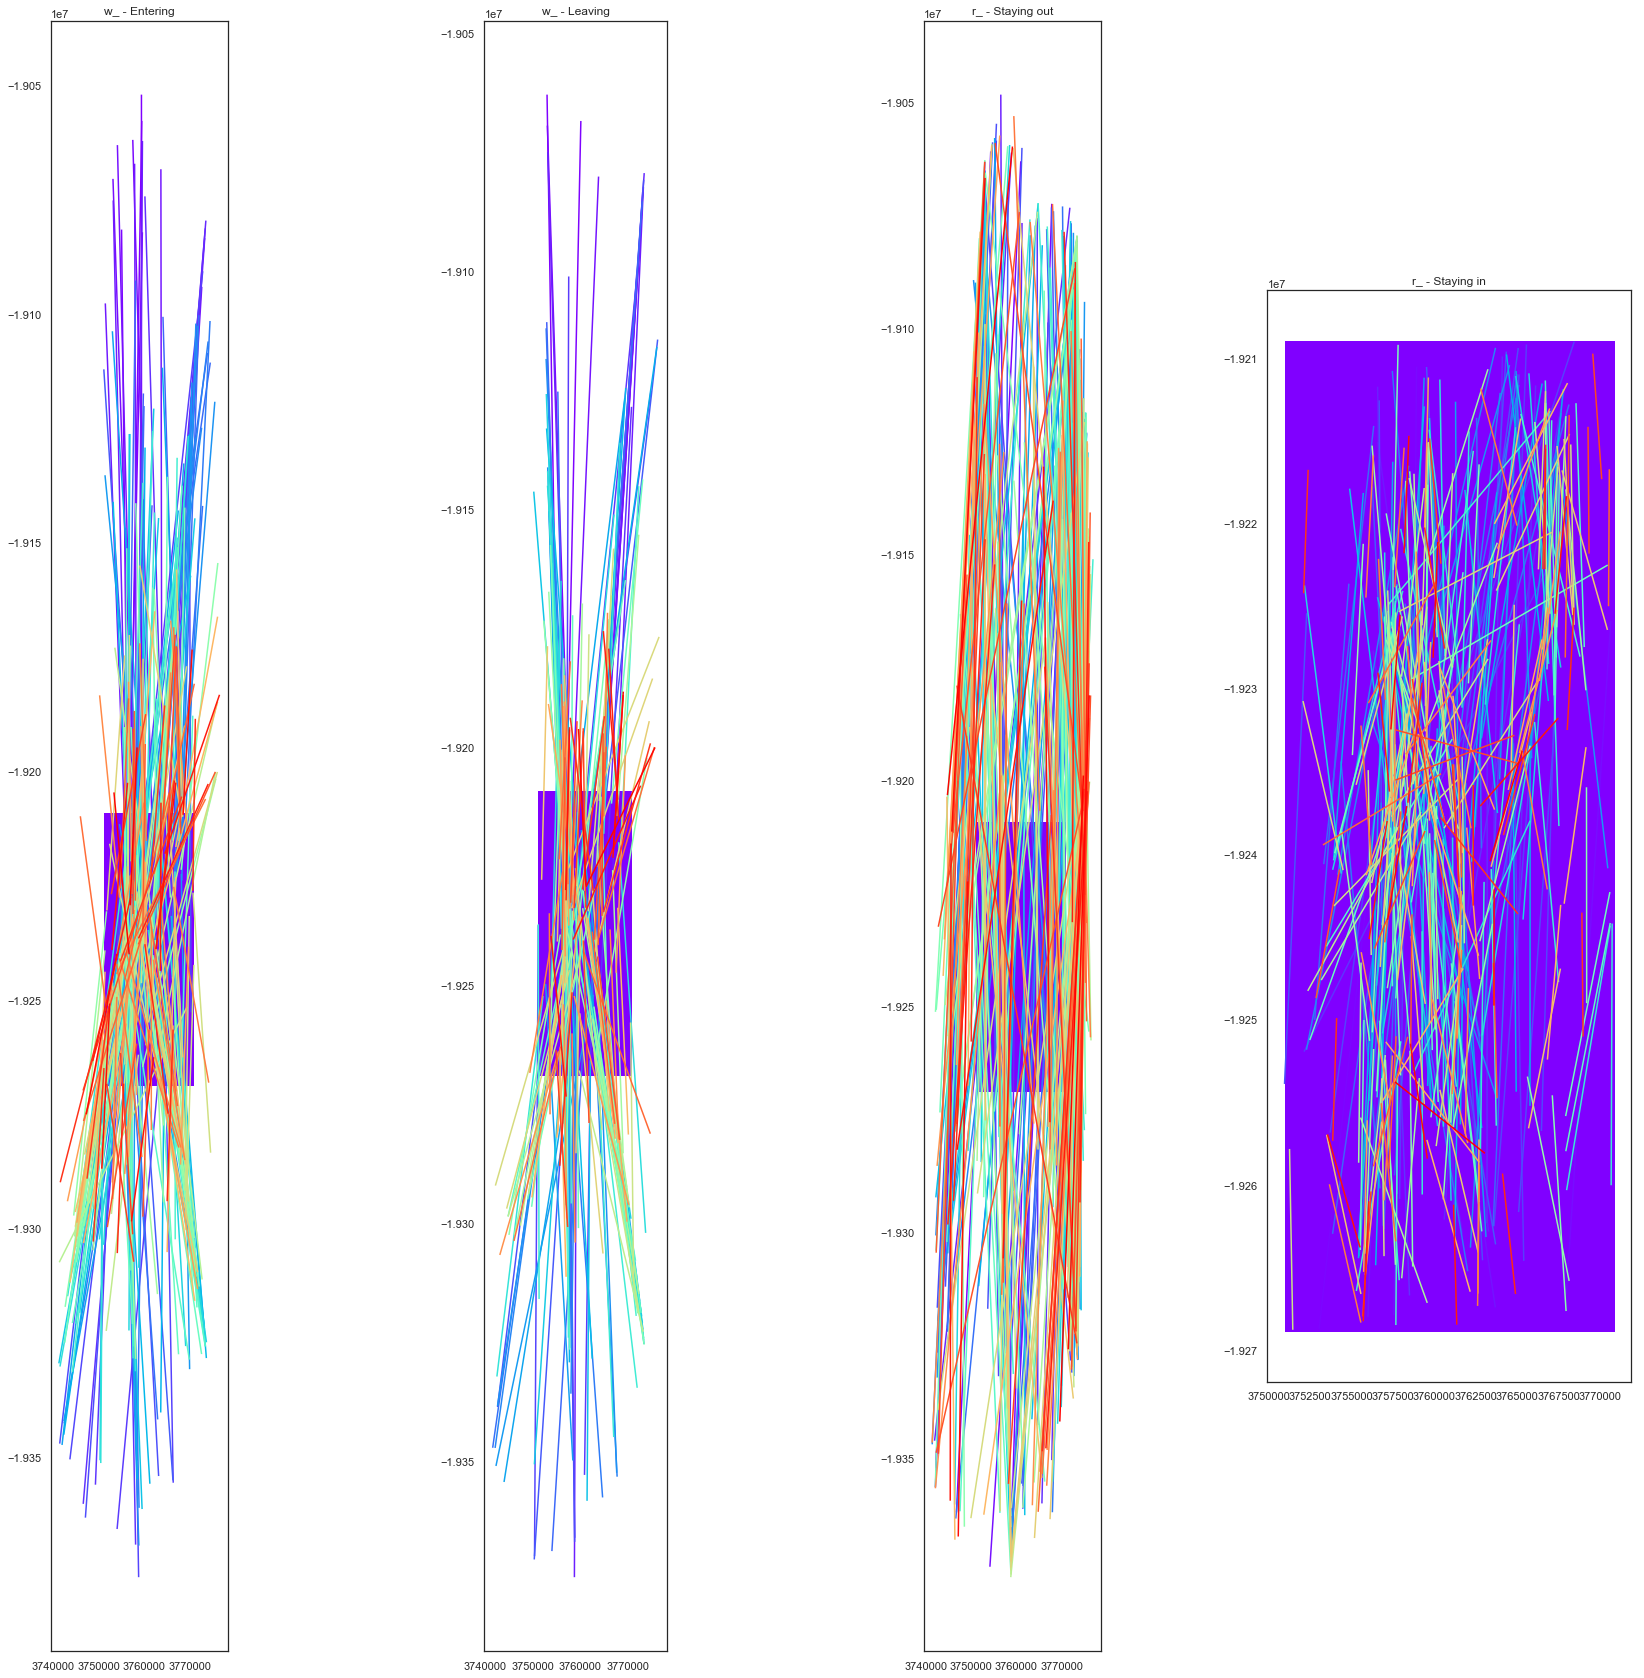

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(30, 30))

ax1.set_title('w_ - Entering')
geoplot(w_long_entering_center.head(500), ax=ax1)
ax2.set_title('w_ - Leaving')
geoplot(w_long_leaving_center.head(500), ax=ax2)
ax3.set_title('r_ - Staying out')
geoplot(r_long_staying_out.head(500), ax=ax3)
ax4.set_title('r_ - Staying in')
geoplot(r_long_staying_in.head(500), ax=ax4)

From `w_`'s distribution throughout its groups, it's visible that whatever means of transport that's being taken to leave and enter the city for the longest travels, it is probably a shared one between both groups. Furthermore, both happen to be going to/coming from the same areas.

Trajectory time distribution.

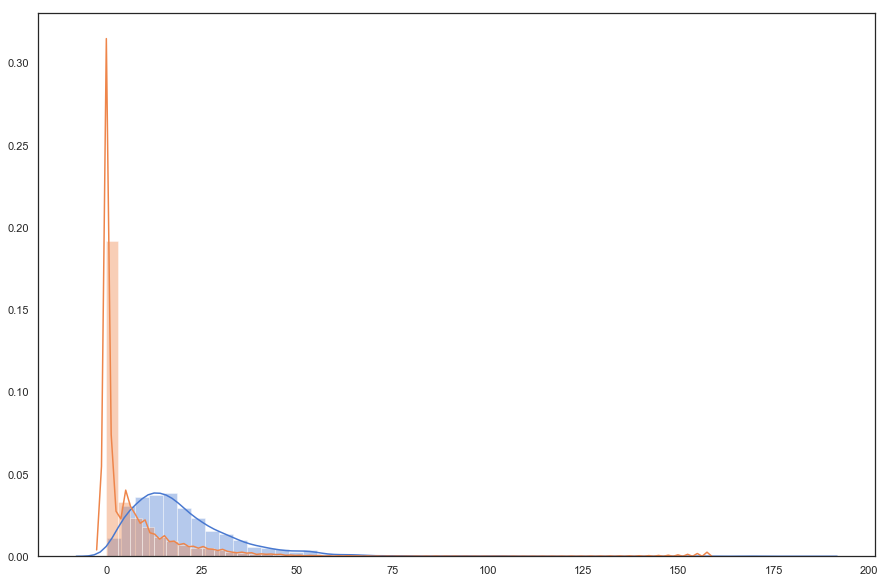

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [47]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
distplot(wrong_preds, 'trajectory_time', label='w_', ax=ax)
distplot(right_preds, 'trajectory_time', label='r_', ax=ax)

Distanciation (positive direction) & approximation to center (negative direction).

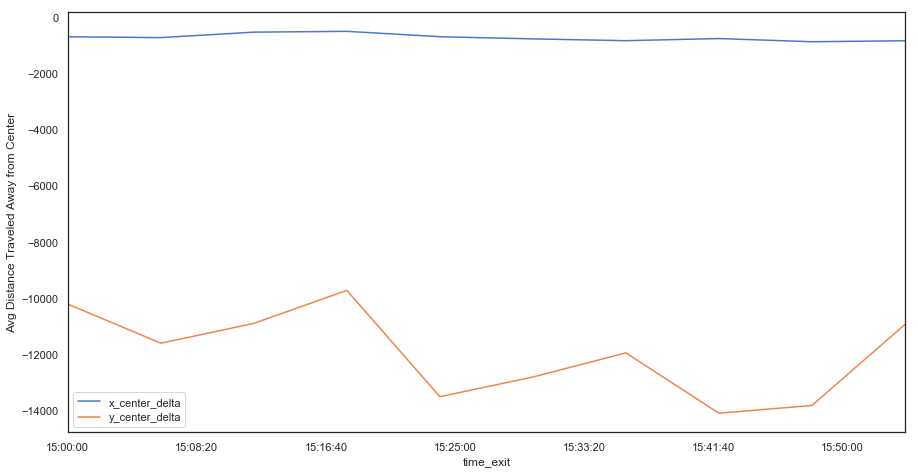

In [15]:
x_delta_avg = wrong_preds.set_index('time_exit').x_center_delta.resample('0.1H').mean()
y_delta_avg = wrong_preds.set_index('time_exit').y_center_delta.resample('0.1H').mean()

plot_avg_distance([x_delta_avg, y_delta_avg], figsize=(15, 17), title='Avg Distance Traveled Away from Center')

Distance distribution

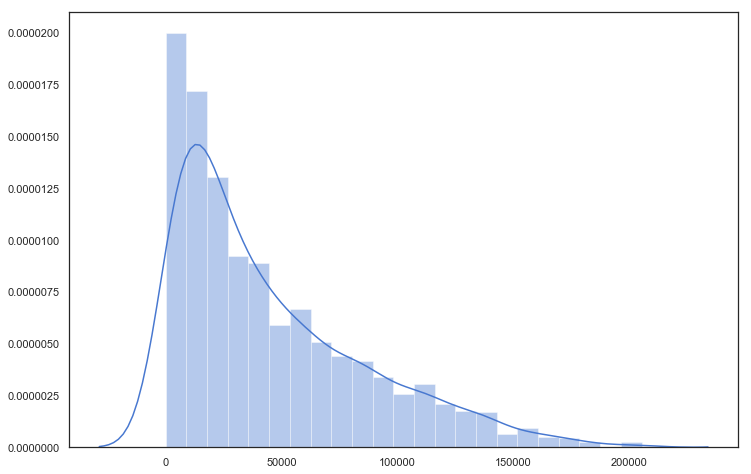

In [16]:
distplot(wrong_preds, index='distance')

In [18]:
grouped = wrong_preds.groupby('hash').distance
print('Skewness: {}'.format(grouped.mean().skew()))
print('Kurtosis: {}'.format(grouped.mean().kurtosis()))

Skewness: 1.144656139937871
Kurtosis: 0.73588941318198


Uniform speed distribution.

In [ ]:
distplot(wrong_preds, index='vuniform')